In [1]:
# Importa bibliotecas necessárias

import html
import pandas as pd
import geopandas as gpd
import os
from math import ceil

In [5]:
# Entra no diretório de dados

os.chdir('C:\\Users\\rgarcia\\Documents\\Data')

In [6]:
# Retira lista de nomes de candidatos a presidente

cands = pd.read_json('https://resultados.tse.jus.br/oficial/ele2022/544/dados/br/br-c0001-e000544-011-f.json').loc['agr', 'carg']
cand_nums = pd.json_normalize(pd.json_normalize(pd.json_normalize(pd.json_normalize(pd.json_normalize(cands, max_level=0)['par'])[0])['cand'])[0])
cand_nums = cand_nums[['n', 'nmu']].dropna()
cand_nums['nmu'] = cand_nums.nmu.apply(lambda x: html.unescape(x).title())
cand_dict = dict(zip(cand_nums.n.to_list(), cand_nums.nmu.to_list()))
cand_dict['22'] = 'Jair Bolsonaro'

In [7]:
# Gera lista de códigos de municipios para injetar no JSON

cod_mun = pd.read_csv('https://raw.githubusercontent.com/rafagarc/eleicoes_2022/main/mapas_1o_turno/codigos_IBGE_TSE.csv')
cod_mun['codigo_tse'] = cod_mun.codigo_tse.astype(str).str.zfill(5)
muns = cod_mun.codigo_tse.to_list()
cod_mun['uf'] = cod_mun.uf.str.lower()
list_mun = cod_mun['uf'].astype(str) + cod_mun['codigo_tse'].astype(str).to_list()

In [8]:
# Gera chassi para concatenar a tabela
munvotes = pd.DataFrame(columns=['muncod', '13', '14', '21', '27', '44', '12', '16', '15', '22', '30', '80'])

# Captura JSON com votação por município, linha a linha
for i in list_mun:
    raw_data = pd.read_json(f'https://resultados.tse.jus.br/oficial/ele2022/544/dados/{i[0:2]}/{i}-c0001-e000544-v.json')
    raw_mun = pd.json_normalize(raw_data['abr']).query('tpabr == "MU"')['cand']
    mun = pd.json_normalize(pd.json_normalize(raw_mun).T[0])
    mun = mun[['n', 'vap']].T
    mun.columns = mun.loc['n']
    mun = mun.drop('n')
    mun.insert(loc=0, column='muncod', value=[i])
    munvotes = pd.concat([munvotes,mun])

# Substitui números por nomes dos candidatos nas colunas
munvotes.columns = [cand_dict[i] if i in cand_dict.keys() else i for i in munvotes.columns]

In [12]:
# Opção de salvar o dataframe de 1o turno ou recarregá-lo

# munvotes.to_csv('munvotes_pres_1t.csv', index=False)

# munvotes = pd.read_csv('munvotes_pres_1t.csv')

In [11]:
# Cria dataframe com votações percentuais

munvotes = munvotes.set_index('muncod')
munvotes = munvotes.astype('int32')
munvotes['TOTAL'] = munvotes.sum(axis=1)
munvotes_pct = (munvotes.drop(columns='TOTAL').div(munvotes.TOTAL, axis=0)*100).round(2)
munvotes_pct['Bolsonaro - Lula (%)'] = (munvotes_pct['Jair Bolsonaro']-munvotes_pct['Lula']).round(2)
munvotes_pct['Votos válidos'] = munvotes.TOTAL

In [18]:
# Cria uma série com os códigos TSE sem zero à esquerda e insere no dataframe

tse_codes = munvotes_pct.index.to_series().apply(lambda x: int(x[-5:]))
munvotes_pct.insert(loc=0, column='codigo_tse', value=tse_codes)

In [21]:
# Carrega conversor de códigos TSE para IBGE e ajusta em colunas no dataframe

tse_ibge = pd.read_csv('https://raw.githubusercontent.com/rafagarc/eleicoes_2022/main/mapas_1o_turno/codigos_IBGE_TSE.csv')
munvotes_agg = tse_ibge.merge(munvotes_pct, how='left', on='codigo_tse')
munvotes_agg['codigo_ibge'] = munvotes_agg.codigo_ibge.astype(str)

In [24]:
# Carrega o mapa de municípios e funde com a tabela de votação 

munmap = gpd.read_file('BR_Municipios_2021_low_res.json')
munmap = munmap.rename(columns={'CD_MUN':'codigo_ibge'})
votemap = munmap.merge(munvotes_agg, on='codigo_ibge', how='left')

In [27]:
# Determina os limites para legenda do plot do Geopandas

legbound = ceil(max((votemap['Bolsonaro - Lula (%)'].min()*-1, votemap['Bolsonaro - Lula (%)'].max())))

<AxesSubplot:>

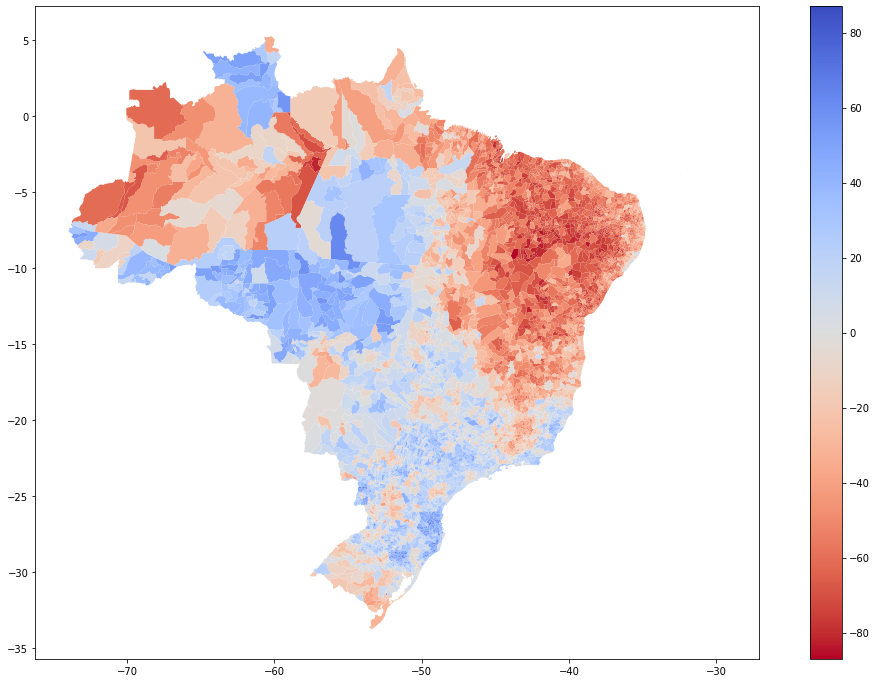

In [73]:
# Plota o mapa de votação 1º turno

votemap.plot(figsize=(18,12), column='Bolsonaro - Lula (%)', cmap='coolwarm_r', legend=True, vmin=-legbound, vmax=legbound)

In [43]:
# AGORA O SEGUNDO TURNO

In [41]:
# Gera chassi para concatenar a tabela

munvotes2 = pd.DataFrame(columns=['muncod', '13', '22'])

# Captura JSON com votação por município, linha a linha

for i in list_mun:
    raw_data2 = pd.read_json(f'https://resultados.tse.jus.br/oficial/ele2022/545/dados/{i[0:2]}/{i}-c0001-e000545-v.json')
    raw_mun2 = pd.json_normalize(raw_data2['abr']).query('tpabr == "MU"')['cand']
    mun2 = pd.json_normalize(pd.json_normalize(raw_mun2).T[0])
    mun2 = mun2[['n', 'vap']].T
    mun2.columns = mun2.loc['n']
    mun2 = mun2.drop('n')
    mun2.insert(loc=0, column='muncod', value=[i])
    munvotes2 = pd.concat([munvotes2,mun2])

# Substitui números por nomes dos candidatos nas colunas
munvotes2.columns = [cand_dict[i] if i in cand_dict.keys() else i for i in munvotes2.columns]

In [45]:
# Opção de salvar ou recarregar a tabela

munvotes2.to_csv('munvotes_pres_2t.csv', index=False)
munvotes2 = pd.read_csv('munvotes_pres_2t.csv')

In [47]:
# Cria tabela com percentual de votação

munvotes2 = munvotes2.set_index('muncod')
munvotes2 = munvotes2.astype('int32')
munvotes2['TOTAL'] = munvotes2.sum(axis=1)
munvotes2_pct = (munvotes2.drop(columns='TOTAL').div(munvotes2.TOTAL, axis=0)*100).round(2)
munvotes2_pct['Bolsonaro - Lula (%)'] = (munvotes2_pct['Jair Bolsonaro']-munvotes2_pct['Lula']).round(2)
munvotes2_pct['Votos válidos'] = munvotes2.TOTAL
munvotes2_pct = munvotes2_pct.fillna(0)

In [64]:
# Emparelha as duas tabelas e retira candidatos que perderam no 1º turno

t1_vs_t2 = munvotes_pct.merge (munvotes2_pct.reset_index(), how='left', on='muncod')

t1_vs_t2 = t1_vs_t2.drop(columns=['Padre Kelmon', 'Sofia Manzano',
       'Constituinte Eymael', 'Soraya Thronicke', 'Ciro Gomes', 'Vera',
       'Simone Tebet', 'Felipe D\'Avila', 'Léo Péricles'])